In [1]:
import os
from pathlib import Path

# Set working directory to Downloads
downloads_path = Path.home() / "Downloads"
os.chdir(downloads_path)

In [2]:
# Confirm it worked
print("Now in:", os.getcwd())

Now in: /Users/rohithr/Downloads


In [3]:
!pip install pandas

In [4]:
!pip install numpy

In [5]:
!pip install matplotlib

In [6]:
!pip install statsmodels

In [7]:
!pip install seaborn

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [9]:
import pandas as pd

# Load CSV
df = pd.read_csv("Crude Oil WTI Futures 10 years.csv")

# Parse Date column
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Set Date as index
df.set_index('Date', inplace=True)

# Drop fully empty columns
df = df.dropna(axis=1, how='all')

# Preview the cleaned data
print(df.head())
# Check structure
print(df.info())
print(df.head())

            Price
Date             
2025-07-24  65.96
2025-07-23  65.46
2025-07-22  66.21
2025-07-21  67.20
2025-07-20  66.18
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2631 entries, 2025-07-24 to 2015-07-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2631 non-null   float64
dtypes: float64(1)
memory usage: 41.1 KB
None
            Price
Date             
2025-07-24  65.96
2025-07-23  65.46
2025-07-22  66.21
2025-07-21  67.20
2025-07-20  66.18


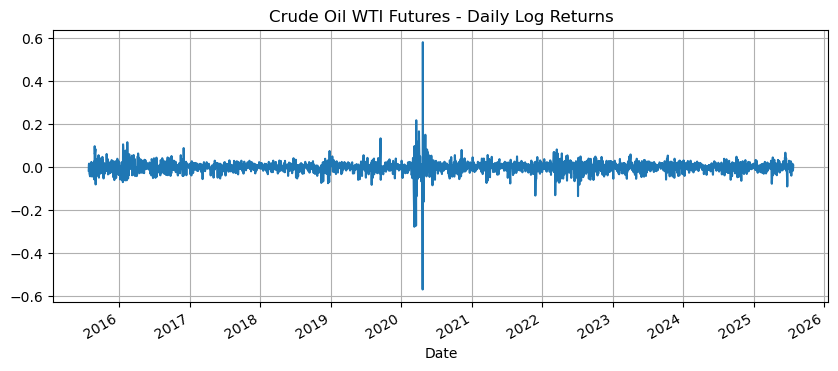

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sort and compute log returns
df.sort_index(inplace=True)
df['LogReturn'] = np.log(df['Price'] / df['Price'].shift(1))
returns = df['LogReturn'].dropna()

# Plot
returns.plot(title="Crude Oil WTI Futures - Daily Log Returns", figsize=(10, 4))
plt.grid(True)
plt.show()

In [11]:
# 95% Historical VaR (1-day)
VaR_hist_95 = np.percentile(returns, 5)

print(f"Historical VaR (95% confidence): {VaR_hist_95:.4%}")

Historical VaR (95% confidence): -3.9755%


In [12]:
mean_return = returns.mean()
std_dev = returns.std()

# Z value for 95% confidence
z_95 = 1.645

# 1-day VaR
VaR_param_95 = -(mean_return - z_95 * std_dev)

print(f"Parametric VaR (95% confidence): {VaR_param_95:.4%}")

Parametric VaR (95% confidence): 5.0224%


In [14]:
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

# Fit GARCH(1,1) to log returns
model = arch_model(returns, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
res = model.fit(disp='off')

# Forecast 1-step ahead variance (next day's volatility)
garch_forecast = res.forecast(horizon=1)
sigma_t = np.sqrt(garch_forecast.variance.iloc[-1, 0])

# Get last observed mean return
mu_t = returns.mean()

# Z-value for 95% confidence
z_95 = 1.645

# GARCH-based 1-day VaR
VaR_garch_95 = -(mu_t - z_95 * sigma_t)

print(f"GARCH-based 1-Day VaR (95%): {VaR_garch_95:.4%}")

GARCH-based 1-Day VaR (95%): 3.4462%


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009362. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


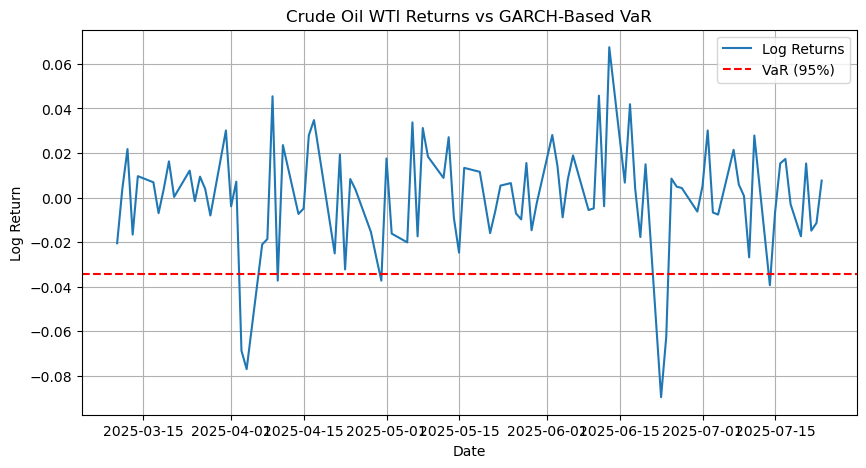

In [15]:
import matplotlib.pyplot as plt

# Plot last 100 days of returns and VaR line
plt.figure(figsize=(10, 5))
plt.plot(returns[-100:], label='Log Returns')
plt.axhline(-VaR_garch_95, color='red', linestyle='--', label='VaR (95%)')
plt.title("Crude Oil WTI Returns vs GARCH-Based VaR")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()